In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from mads_datasets import DatasetFactoryProvider, DatasetType
from mltrainer import ReportTypes, Trainer, TrainerSettings, metrics
from mltrainer.preprocessors import BasePreprocessor

In [3]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, num_classes: int, units: int, depth: int = 1) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.units = units
        self.depth = depth
        self.flatten = torch.nn.Flatten()
        layers = []
        # First hidden layer
        layers.append(torch.nn.Linear(28 * 28, units))
        layers.append(torch.nn.ReLU())
        # Additional hidden layers (if depth > 1)
        for _ in range(depth):
            layers.append(torch.nn.Linear(units, units))
            layers.append(torch.nn.ReLU())
        # Output layer
        layers.append(
            torch.nn.Linear(units, num_classes),
        )
        self.linear_relu_stack = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [4]:
def run_experiments(
    batchsize: int,
    epochs: int,
    learning_rate: float,
    optimizer: torch.optim.Optimizer,
    experiments: list[tuple[int, int, int]],
):
    fashionfactory = DatasetFactoryProvider.create_factory(DatasetType.FASHION)
    preprocessor = BasePreprocessor()
    streamers = fashionfactory.create_datastreamer(
        batchsize=batchsize, preprocessor=preprocessor
    )
    train = streamers["train"]
    valid = streamers["valid"]
    trainstreamer = train.stream()
    validstreamer = valid.stream()

    accuracy = metrics.Accuracy()
    settings = TrainerSettings(
        epochs=epochs,
        metrics=[accuracy],
        logdir="modellogs",
        optimizer_kwargs={"lr": learning_rate},
        train_steps=len(train),
        valid_steps=len(valid),
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML],
    )

    for units, depth in experiments:
        model = NeuralNetwork(
            num_classes=10,
            units=units,
            depth=depth,
        )
        trainer = Trainer(
            model=model,
            settings=settings,
            loss_fn=torch.nn.CrossEntropyLoss(),
            optimizer=optimizer,
            traindataloader=trainstreamer,
            validdataloader=validstreamer,
            scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
        )
        trainer.loop()

In [7]:
batchsize = 64
epochs = 3
learning_rate = 1e-3
optimizer = torch.optim.Adam

units = np.arange(128, 1025, 128)
depths = np.arange(1, 6)
experiments = [(unit, depth) for depth in depths for unit in units]

In [8]:
run_experiments(
    batchsize=batchsize,
    epochs=epochs,
    learning_rate=learning_rate,
    optimizer=optimizer,
    experiments=experiments,
)

2025-10-12 14:13:42.154 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /Users/koendirkvanesterik/.cache/mads_datasets/fashionmnist
2025-10-12 14:13:42.155 | INFO     | mads_datasets.base:download_data:124 - File already exists at /Users/koendirkvanesterik/.cache/mads_datasets/fashionmnist/fashionmnist.pt
2025-10-12 14:13:42.204 | INFO     | mltrainer.settings:check_path:60 - Created logdir /Users/koendirkvanesterik/Projects/mads/mads-ml-koenvanesterik/notebooks/neural-networks/modellogs
2025-10-12 14:13:42.213 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/20251012-141342
2025-10-12 14:13:42.807 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 937/937 [00:01<00:00, 679.66it/s]
2025-10-12 14:13:44.393 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 0.5475 test 0.4411 metric ['0.8408']
100%|██████████| 937/937 [00:01<00:00, 684.85

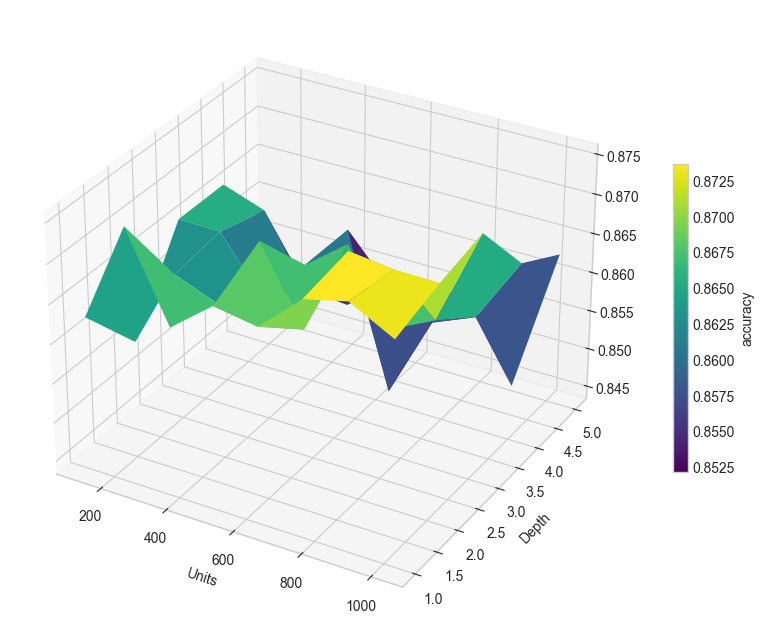

<Figure size 640x480 with 0 Axes>

In [38]:
results = pd.read_csv("results.csv")

# Set theme to dark seaborn
plt.style.use("seaborn-v0_8-whitegrid")

# Pivot the DataFrame to create a grid for surface plot
pivot = results.pivot(index="Depth", columns="Units", values="Value")
X, Y = np.meshgrid(pivot.columns, pivot.index)
Z = pivot.values

fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection="3d")
surf = ax.plot_surface(X, Y, Z, cmap="viridis")
# ax.set_title("Surface Plot")
plt.xlabel("Units")
plt.ylabel("Depth")

cbar = plt.colorbar(surf, ax=ax, shrink=0.5)
cbar.set_label("accuracy")

plt.show()
plt.savefig("../../assets/images/neural_networks_experiments.png")